<a href="https://colab.research.google.com/github/jpmitchell38/PitchClassifierMLB/blob/main/pitch_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv('/content/drive/My Drive/ColabFiles/2019_pitches.csv')
print(df1.head())

     px    pz  start_speed  end_speed    spin_rate     spin_dir  break_angle  \
0  0.00  2.15         88.8       80.7  placeholder  placeholder         22.8   
1  0.34  2.31         89.9       81.8  placeholder  placeholder         22.8   
2 -0.05  2.03         85.7       79.6  placeholder  placeholder          9.6   
3  0.49  0.92         85.4       78.5  placeholder  placeholder         24.0   
4 -0.13  1.11         84.6       77.6  placeholder  placeholder         26.4   

   break_length  break_y     ax  ...  event_num  b_score         ab_id  \
0           4.8     24.0  -8.47  ...          5      0.0  2.019000e+09   
1           3.6     24.0  -7.10  ...          8      0.0  2.019000e+09   
2           6.0     24.0   3.65  ...          9      0.0  2.019000e+09   
3           7.2     24.0 -13.77  ...         10      0.0  2.019000e+09   
4           8.4     24.0 -15.99  ...         11      0.0  2.019000e+09   

   b_count s_count  outs  pitch_num  on_1b  on_2b  on_3b  
0      0.0     

In [4]:
df1.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [5]:
# List of columns to drop
drop_columns = [
    'type_confidence', 'nasty', 'code', 'event_num', 'b_score',
    'ab_id', 'b_count', 's_count', 'outs', 'pitch_num',
    'on_1b', 'on_2b', 'on_3b', 'type', 'zone', 'sz_bot', 'sz_top',
    'y0', 'break_y', 'px', 'x', 'y', 'pz'
]

# Drop them from the DataFrame
df1_cleaned = df1.drop(columns=drop_columns)

In [6]:
df1_cleaned.columns
# df1_cleaned.head()

Index(['start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle',
       'break_length', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'x0', 'z0',
       'pfx_x', 'pfx_z', 'pitch_type'],
      dtype='object')

# Cleaning up columns and adding new columns to help with classification

In [7]:
df1_cleaned.replace('placeholder', np.nan, inplace=True)

df1_cleaned['start_speed'] = pd.to_numeric(df1_cleaned['start_speed'], errors='coerce')
df1_cleaned['end_speed'] = pd.to_numeric(df1_cleaned['end_speed'], errors='coerce')

df1_cleaned.dropna(subset=['pitch_type'], inplace=True)
df1_cleaned = df1_cleaned[~df1_cleaned['pitch_type'].isin(['EP', 'FO'])]

# df1_cleaned['speed_diff'] = df1_cleaned['start_speed'] - df1_cleaned['end_speed']


# df1_cleaned['spin_dir'] = np.degrees(np.arctan2(df1_cleaned['pfx_z'], df1_cleaned['pfx_x']))
# df1_cleaned = df1_cleaned.drop(columns=['spin_rate'])
# df1_cleaned = df1_cleaned.drop(columns=['spin_rate', 'spin_dir'])



# Adding avg_speed
df1_cleaned['avg_speed'] = (df1_cleaned['start_speed'] + df1_cleaned['end_speed']) / 2

# Adding speed_decay_rate - Avoiding division by zero
df1_cleaned['speed_decay_rate'] = np.where(
    df1_cleaned['break_length'] != 0,
    (df1_cleaned['start_speed'] - df1_cleaned['end_speed']) / df1_cleaned['break_length'],
    np.nan  # Assign NaN where break_length is zero
)

# Adding break_intensity
df1_cleaned['break_intensity'] = df1_cleaned['break_angle'] * df1_cleaned['break_length']

# Adding trajectory_angle - Converting to degrees for better interpretability
df1_cleaned['trajectory_angle'] = np.degrees(
    np.arctan(
        df1_cleaned['vz0'] / np.sqrt(df1_cleaned['vx0']**2 + df1_cleaned['vy0']**2)
    )
)

# Adding release_height_diff
df1_cleaned['release_height_diff'] = df1_cleaned['z0'] - df1_cleaned['pfx_z']

# Adding relative_speed - Calculating league average speed for each pitch type
league_avg_speed = df1_cleaned.groupby('pitch_type')['start_speed'].mean()
df1_cleaned['relative_speed'] = df1_cleaned.apply(
    lambda row: row['start_speed'] / league_avg_speed[row['pitch_type']], axis=1
)


df1_cleaned = df1_cleaned.drop(columns=['vz0', 'trajectory_angle', 'ay', 'spin_rate', 'spin_dir'])




df1_cleaned.head()

<ipython-input-7-fd4c05fb6e0f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1_cleaned.replace('placeholder', np.nan, inplace=True)
<ipython-input-7-fd4c05fb6e0f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleaned['avg_speed'] = (df1_cleaned['start_speed'] + df1_cleaned['end_speed']) / 2
<ipython-input-7-fd4c05fb6e0f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,start_speed,end_speed,break_angle,break_length,ax,az,vx0,vy0,x0,z0,pfx_x,pfx_z,pitch_type,avg_speed,speed_decay_rate,break_intensity,release_height_diff,relative_speed
0,88.8,80.7,22.8,4.8,-8.47,-15.51,5.28,-128.95,-1.42,6.07,-5.07,9.98,FF,84.75,1.687500,109.44,-3.91,0.950750
1,89.9,81.8,22.8,3.6,-7.10,-12.99,4.89,-130.54,-1.02,6.20,-4.14,11.18,FF,85.85,2.250000,82.08,-4.98,0.962527
2,85.7,79.6,9.6,6.0,3.65,-22.64,2.33,-124.60,-1.29,6.30,2.30,5.99,SL,82.65,1.016667,57.60,0.31,1.012328
3,85.4,78.5,24.0,7.2,-13.77,-25.74,7.83,-123.74,-1.56,5.85,-8.87,4.14,CH,81.95,0.958333,172.80,1.71,1.010735
4,84.6,77.6,26.4,8.4,-15.99,-28.36,6.79,-122.67,-1.57,5.89,-10.51,2.51,CH,81.10,0.833333,221.76,3.38,1.001267


In [8]:
df1_cleaned.pitch_type.value_counts()

,count
pitch_type,
FF,261485
SL,127680
CH,79939
CU,64166
FT,61044
SI,55361
FC,46339
KC,15324
FS,10538


In [9]:
# CH - Changeup
# CU - Curveball
# FC - Cutter
# FF - Four-seam Fastball
# FS - Splitter
# FT - Two-seam Fastball
# KC - Knuckle curve
# KN - Knuckeball
# SI - Sinker
# SL - Slider

In [10]:
X = df1_cleaned.drop('pitch_type', axis=1)
y = df1_cleaned['pitch_type']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25, random_state=42)

# Train the model
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=42)

In [12]:
y_pred = clf.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9742
Classification Report:
              precision    recall  f1-score   support

          CH       0.96      0.99      0.97     16050
          CU       1.00      1.00      1.00     12778
          FC       1.00      1.00      1.00      9399
          FF       0.98      0.99      0.99     52344
          FS       0.94      0.64      0.76      2142
          FT       0.92      0.90      0.91     12150
          KC       1.00      0.99      0.99      2965
          KN       1.00      0.77      0.87        44
          SI       0.96      0.92      0.94     11089
          SL       0.99      0.99      0.99     25455

    accuracy                           0.97    144416
   macro avg       0.97      0.92      0.94    144416
weighted avg       0.97      0.97      0.97    144416



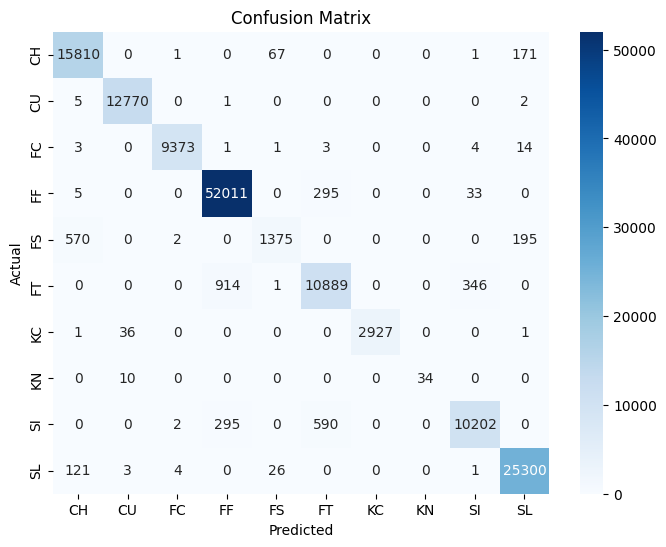

In [14]:
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

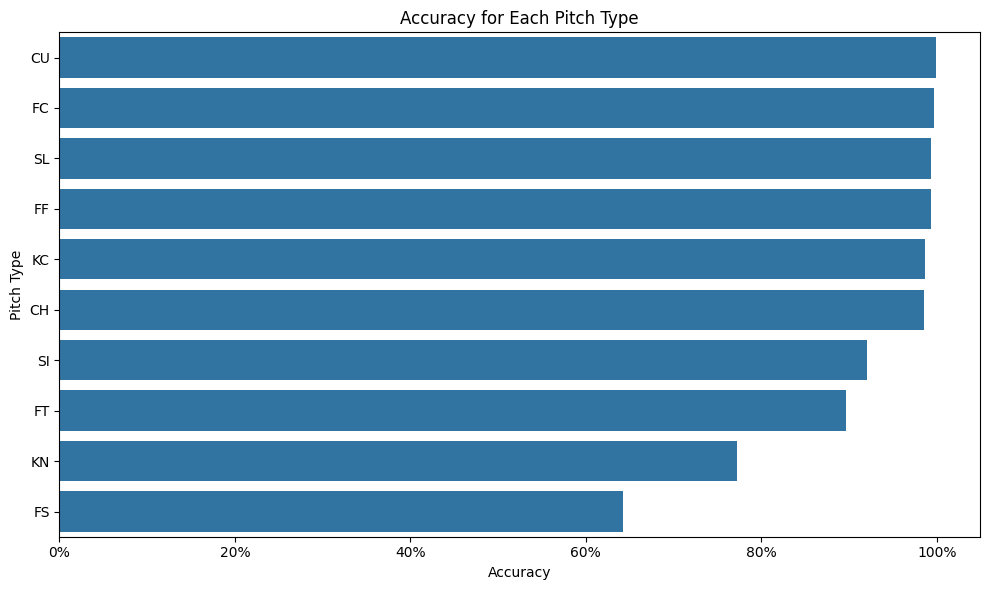

In [15]:
# Get the unique pitch types
pitch_types = df1_cleaned['pitch_type'].unique()

# Calculate accuracy for each pitch type
accuracies = []

for pitch in pitch_types:
    pitch_indices = y_test == pitch
    accuracy = accuracy_score(y_test[pitch_indices], y_pred[pitch_indices])
    accuracies.append(accuracy)

# Create a DataFrame for plotting
accuracy_df = pd.DataFrame({
    'Pitch Type': pitch_types,
    'Accuracy': accuracies
})

# Sort the accuracy values in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Pitch Type', data=accuracy_df)

# Format the x-axis labels as percentages and remove redundant ticks
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[:-1])
ax.set_xticklabels([f'{x*100:.0f}%' for x in ax.get_xticks()])

# Add titles and labels
plt.title('Accuracy for Each Pitch Type')
plt.xlabel('Accuracy')
plt.ylabel('Pitch Type')
plt.tight_layout()
plt.show()

                Feature  Importance
16       relative_speed    0.189788
3          break_length    0.108408
0           start_speed    0.079855
5                    az    0.075689
7                   vy0    0.070475
15  release_height_diff    0.068828
13     speed_decay_rate    0.047004
11                pfx_z    0.046595
14      break_intensity    0.044370
2           break_angle    0.043943
1             end_speed    0.036434
8                    x0    0.036238
12            avg_speed    0.035603
10                pfx_x    0.034441
4                    ax    0.033148
9                    z0    0.025704
6                   vx0    0.023477


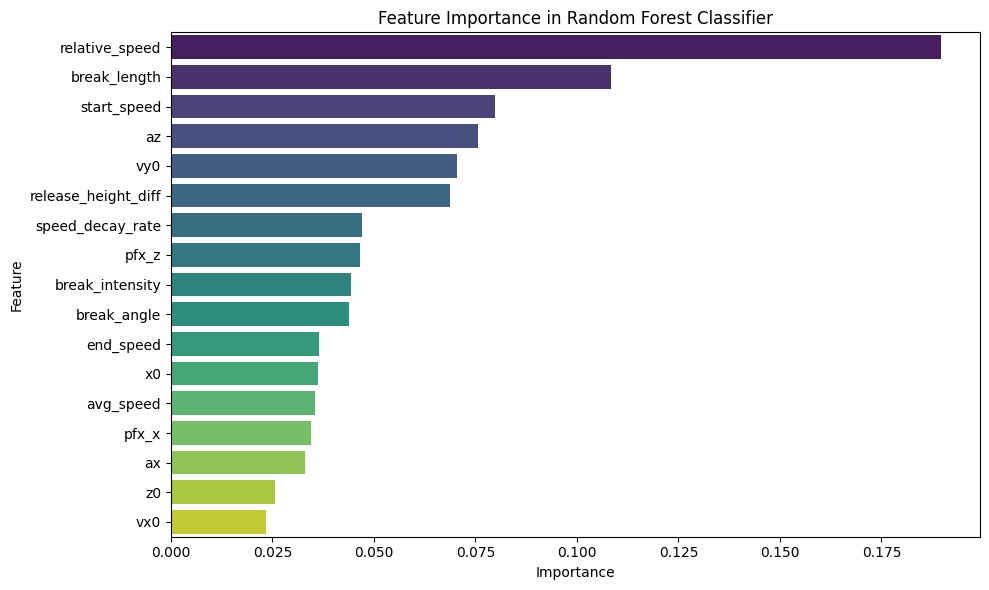

In [16]:
importances = clf.feature_importances_

# Create a DataFrame to display the importance values
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature')
plt.title('Feature Importance in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()